In [97]:
import cirq
import numpy as np

from cirq import Circuit
from cirq.devices import GridQubit
from cirq.google import XmonSimulator

n = 4

In [98]:
qubits = [cirq.GridQubit(x, y) for x in range(n) for y in range(n)]
print(qubits)

[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(1, 3), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2), cirq.GridQubit(2, 3), cirq.GridQubit(3, 0), cirq.GridQubit(3, 1), cirq.GridQubit(3, 2), cirq.GridQubit(3, 3)]


In [99]:
# Goal: Simulate an Ising chain of n-qubits, using only log(n) qubits
# Specifically, the paper does a four qubit Ising chain using two qubits
# We must decompose the circuits for compressed simulation into the available gate set.
# We must also run the experiment often enough so that statistical errors are reduced
# Systematic errors must be estimated using independent controlled circuits of 
# similar complexity to the one of interest. Since we are running in simulation via Cirq, this may be less of an issue.

In [100]:
cz01 = cirq.CZ(qubits[0], qubits[1])
x2 = cirq.X(qubits[2])
cz12 = cirq.CZ(qubits[1], qubits[2])
moment0 = cirq.Moment([cz01, x2])
moment1 = cirq.Moment([cz12])
circuit = cirq.Circuit((moment0, moment1))

print(circuit)

(0, 0): ───@───────
           │
(0, 1): ───@───@───
               │
(0, 2): ───X───@───


In [101]:
def s_dag():
    shape = (2, 2)
    gate = np.zeros(shape, dtype=np.complex_)
    gate[0][0] = 1.0
    gate[0][1] = 0.0
    gate[1][0] = 0.0
    gate[1][1] = -1j
    return cirq.SingleQubitMatrixGate(gate)

SDag = s_dag()

In [102]:
qubits = cirq.LineQubit.range(3)
first, second, third = qubits
def ising_circuit():
    circuit = cirq.Circuit()

    circuit.append([cirq.H(first), cirq.H(third)])
    circuit.append([cirq.S(first)**-1, cirq.CNOT(control=third, target=second)])
    circuit.append([cirq.H(first)])
    
    circuit.append([cirq.CNOT(control=first, target=second)])
    circuit.append([cirq.Z(first)])
    circuit.append([cirq.H(first)])
    circuit.append([cirq.CNOT(control=first, target=second)])
    circuit.append([cirq.S(first), cirq.T(second)])
    circuit.append([cirq.H(first), cirq.Z(second)])
    circuit.append([cirq.CNOT(control=first, target=second)])
    circuit.append([cirq.T(first)])
    circuit.append([cirq.H(first)])
    circuit.append([cirq.T(first)])
    
    # S-H-T * 4 on first qubit
    for _ in range(4):
        circuit.append([cirq.S(first)])
        circuit.append([cirq.H(first)])
        circuit.append([cirq.T(first)])

    # H T H T-1 H T-1 H T Z H Measurement
    circuit.append([cirq.H(first)])
    circuit.append([cirq.T(first)])
    circuit.append([cirq.H(first)])
    circuit.append([cirq.T(first)**-1])
    circuit.append([cirq.H(first)])
    circuit.append([cirq.T(first)**-1])
    circuit.append([cirq.H(first)])
    circuit.append([cirq.T(first)])
    circuit.append([cirq.Z(first)])
    circuit.append([cirq.H(first)])
    
    return circuit
  
circuit = ising_circuit()
circuit

0: ───H───S^-1───H───@───Z───H───@───S───H───@───T───H───T───S───H───T───S───H───T───S───H───T───S───H───T───H───T───H───T^-1───H───T^-1───H───T───Z───H───
                     │           │           │
1: ───────X──────────X───────────X───T───Z───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────
          │
2: ───H───@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [103]:
simulator = cirq.Simulator()
circuit.append([cirq.measure(first, key='x')])
reps = 100
results = simulator.run(circuit, repetitions=reps)
wave_function = simulator.simulate(circuit, qubit_order=qubits)

In [104]:
hist = dict(results.histogram(key='x'))
for k in hist:
    v = hist[k]
    hist[k] = v/reps
    
print(hist)

# 0 -> +1
# 1 -> -1
# hist[-1] = hist[1]
# hist[1] = hist[0]
# del hist[0]
# hist

{1: 0.09, 0: 0.91}


In [105]:
wave_function

measurements: x=0
output vector: (-0.274-0.418j)|000⟩ + (0.418-0.274j)|001⟩ + (-0.102+0.489j)|010⟩ + (0.489+0.102j)|011⟩

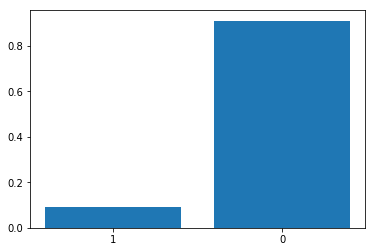

In [108]:
plt.bar(range(len(hist)), hist.values(), align='center')
plt.xticks(range(len(hist)), list(hist.keys()))

plt.show()

In [ ]:
# J = 1
# https://github.com/quantumlib/Cirq/blob/master/examples/quantum_teleportation.py
    # Creates Bell state to be shared between Alice and Bob
    circuit.append([cirq.H(alice), cirq.CNOT(alice, bob)])
    # Creates a random state for the Message
    circuit.append([cirq.X(msg)**ranX, cirq.Y(msg)**ranY])
    # Bell measurement of the Message and Alice's entangled qubit
    circuit.append([cirq.CNOT(msg, alice), cirq.H(msg)])
    circuit.append(cirq.measure(msg, alice))
    # Uses the two classical bits from the Bell measurement to recover the
    # original quantum Message on Bob's entangled qubit
    circuit.append([cirq.CNOT(alice, bob), cirq.CZ(msg, bob)])